In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer

import warnings
import re
import pandas as pd

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

c:\Users\Igor\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## <b> Leitura da Base

In [2]:
def split_focal(row):
    focals = row['Focal'].split(' | ')
    new_rows = []
    for focal in focals:
        new_row = row.copy()
        new_row['Focal'] = focal
        new_rows.append(new_row)
    return new_rows

df = pd.read_excel('Base - FeedBacks Clientes.xlsx')
list_of_new_rows = df.apply(split_focal, axis=1).tolist()
new_rows = [row for rows in list_of_new_rows for row in rows]
df = pd.DataFrame(new_rows)

df['Focal'].replace('Gestão de terceiros', 'Gestão de Terceiros', inplace=True)
df['Focal'].replace('comercial','Comercial', inplace=True)

df = df[['Mapeamento_Final', 'Focal']]
df

,Mapeamento_Final,Focal
0,"Foi uma ligação de deste entre a operadora e possivelmente alguém responsável por realizar reparos no sistema, pois se cumprimentam ligação fica muda e após confirmar que foi autorizado ambos desligam",Não necessário
1,Foi uma ligação de teste,Não necessário
2,"Correspondente informa que começou a menos de semanas a trabalhar com expresso e que já recebeu todo o maquinário e ao ser questionado se já entraram em contato para fazer o treinamento correspondente só informam que ligaram há algum tempo fazendo as mesmas perguntas, mas não confirmou se já fez o treinamento, mas confirmou está tudo bem e que se sente segura a fazer as transações finaliza informando que estava ocupada e qualquer dúvida perguntará ao gerente",Não necessário
3,"Correspondente informa que não está transacionando, pois não tem internet há mais de uma semana por problema na operadora dele, mas tem vontade de voltar transacionar correspondente solicita uma máquina mais moderna",Gestão de Terceiros
4,"Correspondente informa que já foi instalado a máquina e já recebeu o treinamento informa que não tem dúvidas e que em tudo que precisa o sistema já está o atendendo correspondente informa que ainda não se cadastrou no site do expresso correspondente não tinha o telefone do gerente, mas anotou o e-mail do canal de atendimento correspondente informa que no momento está apenas fazendo deposito e pagamentos, mas irá ativar demais funcionalidades aos poucos",Não necessário
...,...,...
1422,"Informou que como faz pouco tempo que está como correspondente está concentrando as operações somente com ele, porém ele se ausentou, pois fez uma cirurgia, mas já está retornando aos poucos",Não necessário
1423,"Correspondente disse que a implantação foi um sucesso teve uma dúvida quanto o saque, mas passei o número do coordenador para ele poder sanar as dúvidas",Não necessário
1424,"A implantação da maquininha foi finalizada, mas ainda não trabalha com negócios disse que combinou com a gerente de apresentar e ver se vai colocar na loja",Não necessário
1425,"Informou que a implantação foi finalizada, mas de acordo com ela não é viável manter, pois demanda muito tempo que ela não tem já conversou com o gerente e o material está aguardando esperado o contato dos responsáveis trocar",Comercial


### <B> Distribuição das Categorias

In [3]:
df['Focal'].value_counts()

Focal
Não necessário         731
Comercial              337
Gestão de Terceiros    220
Implantação            119
Estratégia              50
Marketing               26
Name: count, dtype: int64

### <B> Pré-Processamento e Vetorização

In [4]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
rs = RSLPStemmer()
stop_words = set(stopwords.words('portuguese'))

# Função para remover pontuação
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text) # Utilizamos a expressão regular para substituir qualquer pontuação por uma string vazia ''

# Função de pré-processamento
def preprocess(text):
    text = remove_punctuation(text)  # Remove pontuação
    text = text.lower()  # Converte o texto para minúsculas
    words = word_tokenize(text)  # Tokeniza o texto (divide em palavras)
    words = [word for word in words if word not in stop_words]  # Remove as stopwords
    words = [rs.stem(word) for word in words]  # Extrai o radical de cada palavra (Stemming)
    return words

df['words'] = df['Mapeamento_Final'].apply(preprocess)
df

,Mapeamento_Final,Focal,words
0,"Foi uma ligação de deste entre a operadora e possivelmente alguém responsável por realizar reparos no sistema, pois se cumprimentam ligação fica muda e após confirmar que foi autorizado ambos desligam",Não necessário,"[lig, dest, oper, possi, alguém, respons, realiz, repar, sistem, poi, cumpriment, lig, fic, mud, após, confirm, autor, ambos, deslig]"
1,Foi uma ligação de teste,Não necessário,"[lig, test]"
2,"Correspondente informa que começou a menos de semanas a trabalhar com expresso e que já recebeu todo o maquinário e ao ser questionado se já entraram em contato para fazer o treinamento correspondente só informam que ligaram há algum tempo fazendo as mesmas perguntas, mas não confirmou se já fez o treinamento, mas confirmou está tudo bem e que se sente segura a fazer as transações finaliza informando que estava ocupada e qualquer dúvida perguntará ao gerente",Não necessário,"[correspond, inform, começ, menos, seman, trabalh, express, receb, tod, maquin, question, entr, contat, faz, trein, correspond, inform, lig, algum, temp, faz, mesm, pergunt, confirm, fez, trein, confirm, tud, bem, sent, segur, faz, trans, finaliz, inform, ocup, qualqu, dúv, pergunt, gerent]"
3,"Correspondente informa que não está transacionando, pois não tem internet há mais de uma semana por problema na operadora dele, mas tem vontade de voltar transacionar correspondente solicita uma máquina mais moderna",Gestão de Terceiros,"[correspond, inform, transacion, poi, internet, seman, problem, oper, vontad, volt, transac, correspond, solicit, máquin, modern]"
4,"Correspondente informa que já foi instalado a máquina e já recebeu o treinamento informa que não tem dúvidas e que em tudo que precisa o sistema já está o atendendo correspondente informa que ainda não se cadastrou no site do expresso correspondente não tinha o telefone do gerente, mas anotou o e-mail do canal de atendimento correspondente informa que no momento está apenas fazendo deposito e pagamentos, mas irá ativar demais funcionalidades aos poucos",Não necessário,"[correspond, inform, instal, máquin, receb, trein, inform, dúv, tud, precis, sistem, atend, correspond, inform, aind, cadastr, sit, express, correspond, telefon, gerent, anot, email, canal, atend, correspond, inform, moment, apen, faz, deposit, pag, irá, ativ, demal, funcional, pouc]"
...,...,...,...
1422,"Informou que como faz pouco tempo que está como correspondente está concentrando as operações somente com ele, porém ele se ausentou, pois fez uma cirurgia, mas já está retornando aos poucos",Não necessário,"[inform, faz, pouc, temp, correspond, concentr, oper, soment, porém, ausent, poi, fez, cirurg, retorn, pouc]"
1423,"Correspondente disse que a implantação foi um sucesso teve uma dúvida quanto o saque, mas passei o número do coordenador para ele poder sanar as dúvidas",Não necessário,"[correspond, diss, implant, sucess, dúv, quant, saqu, pass, númer, coorden, pod, san, dúv]"
1424,"A implantação da maquininha foi finalizada, mas ainda não trabalha com negócios disse que combinou com a gerente de apresentar e ver se vai colocar na loja",Não necessário,"[implant, maquin, final, aind, trabalh, negóci, diss, combin, gerent, apresent, ver, vai, coloc, loj]"
1425,"Informou que a implantação foi finalizada, mas de acordo com ela não é viável manter, pois demanda muito tempo que ela não tem já conversou com o gerente e o material está aguardando esperado o contato dos responsáveis trocar",Comercial,"[inform, implant, final, acord, vi, mant, poi, demand, temp, convers, gerent, mater, aguard, esper, contat, respons, troc]"


### <B> Estruturação da função de Jaccard e Aplicação

In [6]:
# Função para calcular a Similaridade de Jaccard
def jaccard_similarity(list1, list2):
    """
    Calcula a Similaridade de Jaccard entre dois conjuntos de palavras.
    Jaccard(A, B) = |A ∩ B| / |A ∪ B|
    """
    s1 = set(list1)  # Converte a lista 1 em um conjunto (set)
    s2 = set(list2)  # Converte a lista 2 em um conjunto (set)
    
    intersection = s1.intersection(s2)  # Calcula a interseção dos conjuntos
    union = s1.union(s2)  # Calcula a união dos conjuntos
    
    if len(union) == 0:
        return 0  # Previne divisão por zero caso ambos os conjuntos sejam vazios
    
    jaccard_score = len(intersection) / len(union)  # Calcula a Similaridade de Jaccard
    return jaccard_score


# Função de Classificação usando Similaridade de Jaccard
def classify_with_jaccard(train_data):
    predicted_categories = []
    
    # Itera sobre cada linha do dataset
    for i, row in df.iterrows():
        words = row['words']  # Pega o texto pré-processado da linha atual
        max_similarity = 0  # Inicializa a maior similaridade como 0
        predicted_category = None  # Inicializa a categoria prevista como None
        
        # Itera sobre todas as outras linhas para comparar
        for j, comparison_row in df.iterrows():
            if i != j:  # Evita auto-comparação
                comparison_words = comparison_row['words']  # Pega o texto da linha a ser comparada
                similarity = jaccard_similarity(words, comparison_words)  # Calcula a similaridade de Jaccard
                
                if similarity > max_similarity:  # Se a similaridade for maior que a máxima até agora
                    max_similarity = similarity  # Atualiza a maior similaridade
                    predicted_category = comparison_row['Focal']  # Atualiza a categoria prevista
        
        predicted_categories.append(predicted_category)  # Armazena a categoria prevista para essa linha
    
    # Adiciona a coluna 'Focal_Previsto' com as categorias previstas
    df['Focal_Previsto'] = predicted_categories
    return df

df_classified = classify_with_jaccard(df)

df_classified[['Mapeamento_Final', 'Focal', 'Focal_Previsto']].head()

,Mapeamento_Final,Focal,Focal_Previsto
0,"Foi uma ligação de deste entre a operadora e possivelmente alguém responsável por realizar reparos no sistema, pois se cumprimentam ligação fica muda e após confirmar que foi autorizado ambos desligam",Não necessário,Não necessário
1,Foi uma ligação de teste,Não necessário,Não necessário
2,"Correspondente informa que começou a menos de semanas a trabalhar com expresso e que já recebeu todo o maquinário e ao ser questionado se já entraram em contato para fazer o treinamento correspondente só informam que ligaram há algum tempo fazendo as mesmas perguntas, mas não confirmou se já fez o treinamento, mas confirmou está tudo bem e que se sente segura a fazer as transações finaliza informando que estava ocupada e qualquer dúvida perguntará ao gerente",Não necessário,Não necessário
3,"Correspondente informa que não está transacionando, pois não tem internet há mais de uma semana por problema na operadora dele, mas tem vontade de voltar transacionar correspondente solicita uma máquina mais moderna",Gestão de Terceiros,Não necessário
4,"Correspondente informa que já foi instalado a máquina e já recebeu o treinamento informa que não tem dúvidas e que em tudo que precisa o sistema já está o atendendo correspondente informa que ainda não se cadastrou no site do expresso correspondente não tinha o telefone do gerente, mas anotou o e-mail do canal de atendimento correspondente informa que no momento está apenas fazendo deposito e pagamentos, mas irá ativar demais funcionalidades aos poucos",Não necessário,Não necessário


## <b> Avaliação do Desempenho do Modelo

In [9]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


Contagem de rótulos reais: Counter({'Não necessário': 731, 'Comercial': 337, 'Gestão de Terceiros': 220, 'Implantação': 119, 'Estratégia': 50, 'Marketing': 26})
Contagem de rótulos previstos: Counter({'Não necessário': 869, 'Gestão de Terceiros': 277, 'Comercial': 222, 'Implantação': 70, 'Estratégia': 37, 'Marketing': 8})

--- Avaliação Geral do Modelo ---
Acurácia: 0.6264
Precisão (Ponderada): 0.6085
Revocação (Ponderada): 0.6264
F1-score (Ponderado): 0.6055

--- Especificidade por Classe ---
Classe Não necessário: Especificidade = 0.6489
Classe Comercial: Especificidade = 0.9197
Classe Gestão de Terceiros: Especificidade = 0.8979
Classe Implantação: Especificidade = 0.9714
Classe Estratégia: Especificidade = 0.9826
Classe Marketing: Especificidade = 0.9966


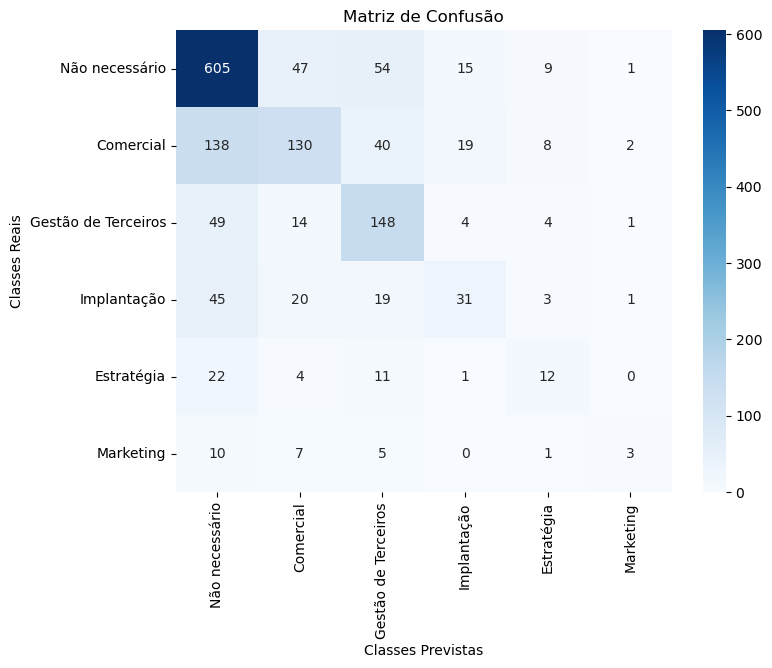

In [10]:
# Função para avaliar a performance do modelo com Jaccard
def evaluate_jaccard_classification(df_classified, true_column, predicted_column, class_labels):
    true_labels = df_classified[true_column]
    predicted_labels = df_classified[predicted_column]
    
    # Imprimindo a distribuição de rótulos reais e previstos para verificar discrepâncias
    print("\nContagem de rótulos reais:", Counter(true_labels))
    print("Contagem de rótulos previstos:", Counter(predicted_labels))
    
    # Calcula a acurácia
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Calcula a precisão ponderada
    precision = precision_score(true_labels, predicted_labels, average='weighted')

    # Calcula a revocação ponderada
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    # Calcula o F1-score ponderado
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calcula a matriz de confusão
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

    # Calcula a especificidade (usando a matriz de confusão)
    specificity_per_class = []
    for i in range(conf_matrix.shape[0]):
        tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
        specificity = tn / (tn + fp)
        specificity_per_class.append(specificity)

    # Exibe os resultados gerais
    print(f"\n--- Avaliação Geral do Modelo ---")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão (Ponderada): {precision:.4f}")
    print(f"Revocação (Ponderada): {recall:.4f}")
    print(f"F1-score (Ponderado): {f1:.4f}")

    # Exibe a especificidade por classe
    print(f"\n--- Especificidade por Classe ---")
    for idx, specificity in enumerate(specificity_per_class):
        print(f"Classe {class_labels[idx]}: Especificidade = {specificity:.4f}")

    # Plotando a matriz de confusão com valores absolutos
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Matriz de Confusão')
    plt.xlabel('Classes Previstas')
    plt.ylabel('Classes Reais')
    plt.show()


# Certifique-se de que as colunas 'Focal' e 'Focal_Previsto' estão como strings
df_classified['Focal'] = df_classified['Focal'].astype(str)
df_classified['Focal_Previsto'] = df_classified['Focal_Previsto'].astype(str)

# Lista de classes para exibição da matriz de confusão e cálculo de especificidade
class_labels = ['Não necessário', 'Comercial', 'Gestão de Terceiros', 'Implantação', 'Estratégia', 'Marketing']

# Avaliando o modelo com a função de avaliação Jaccard
evaluate_jaccard_classification(df_classified, 'Focal', 'Focal_Previsto', class_labels)
